### Importing libraries

In [1]:
# Import default libraries
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import seaborn as sns
import time
import random
import warnings
import os
import requests
import json
import time
import zipfile
import logging
# Import Biopython utils
from Bio.PDB import PDBList, calc_angle, calc_dihedral, PPBuilder, is_aa, PDBIO, NeighborSearch, DSSP, HSExposureCB
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select
# Import custom libraries
from modules.feature_extraction import *

In [2]:
# Set debug info
logging.basicConfig(level=logging.DEBUG)

### Helping functions

### Importing original dataset (LIP tagged sequences)

In [3]:
def down_sampling(df, number_of_samples, seed = 42):
    noLIP_index = set(df[df['LIP'] == 0].index)
    indexes = set(np.arange(0, np.shape(df)[0]))
    sample = random.sample(noLIP_index, len(noLIP_index) - number_of_samples)
    new_index = indexes.difference(sample)
    df1 = df.iloc[list(new_index), :]
    return df1

# Turns an angle from radiants to degrees 
def rad_to_deg(rad_angle):
    # If the input is None, then it returns None.
    # For numerical input, the output is mapped to [-180,180]
    if rad_angle is None :
        return None
    # Computes angle in degrees
    angle = rad_angle * 180 / math.pi
    # Handles radiants conversion
    while angle > 180 :
        angle = angle - 360
    while angle < -180 :
        angle = angle + 360
    return angle

In [4]:
# Read original dataset (lips_dataset)
ds_original = pd.read_csv('./datasets/lips_dataset_02.txt', sep='\t')
# Define new dataset
ds_original.head()

,pdb,chain,start,end,type
0,1cee,A,neg,neg,long
1,1cee,B,1,47,long
2,1dev,A,neg,neg,long
3,1dev,B,669,709,long
4,1dow,A,neg,neg,long


### Downloading proteins (automatically skips a protein if it has already been downloaded)

In [5]:
# Select all proteins (pdb column)
pdb_ids = ds_original.pdb.unique()
# Define pdb files dir
pdb_dir = './pdb_files'
# Define pdb file fetching class
pdbl = PDBList()
# Fetch every protein
for pdb_id in pdb_ids:
    # Execute fetching of the protein (pdb file)
    pdbl.retrieve_pdb_file(pdb_id, pdir=pdb_dir, file_format='pdb')

Structure exists: './pdb_files/pdb1cee.ent' 
Structure exists: './pdb_files/pdb1dev.ent' 
Structure exists: './pdb_files/pdb1dow.ent' 
Structure exists: './pdb_files/pdb1fqj.ent' 
Structure exists: './pdb_files/pdb1g3j.ent' 
Structure exists: './pdb_files/pdb1hrt.ent' 
Structure exists: './pdb_files/pdb1i7w.ent' 
Structure exists: './pdb_files/pdb1j2j.ent' 
Structure exists: './pdb_files/pdb1jsu.ent' 
Structure exists: './pdb_files/pdb1kil.ent' 
Structure exists: './pdb_files/pdb1l8c.ent' 
Structure exists: './pdb_files/pdb1p4q.ent' 
Structure exists: './pdb_files/pdb1pq1.ent' 
Structure exists: './pdb_files/pdb1q68.ent' 
Structure exists: './pdb_files/pdb1rf8.ent' 
Structure exists: './pdb_files/pdb1sc5.ent' 
Structure exists: './pdb_files/pdb1sqq.ent' 
Structure exists: './pdb_files/pdb1tba.ent' 
Structure exists: './pdb_files/pdb1th1.ent' 
Structure exists: './pdb_files/pdb1xtg.ent' 
Structure exists: './pdb_files/pdb1ymh.ent' 
Structure exists: './pdb_files/pdb1zoq.ent' 
Structure 

### Creating redidues dataset

In [6]:
# Select all proteins (pdb column)
pdb_ids = ds_original.pdb.unique()
# Define pdb files dir
pdb_dir = './pdb_files'
# Define pdb file fetching class
pdbl = PDBList()

In [7]:
# Define a set containing (pdb_id, chain_id)
valid_chains = set([(row['pdb'], row['chain']) for idx, row in ds_original.iterrows()])

In [8]:
# New list for residues
ds_residues = list()
# Loop thorugh every protein
for pdb_id in ds_original.pdb.unique():
    # Get structure of the protein
    structure = PDBParser(QUIET=True).get_structure(pdb_id, pdb_dir + '/pdb{}.ent'.format(pdb_id))
    # We select only the 0-th model
    model = structure[0]
    # Loop through every model's chain
    for chain in model:
        # Skip if the chain is not valid
        if (pdb_id, chain.id) not in valid_chains:
            continue
        for residue in chain:
            # Do not take into account non-aminoacidic residues (e.g. water molecules)
            if(not is_aa(residue)): 
                continue
            # Add an entry to the residues list
            ds_residues.append((pdb_id, model.id, chain.id, residue.id[1], residue.get_resname(), 0, 0))

                                   
# Turn list into dataframe
ds_residues = pd.DataFrame(ds_residues)
# Define dataset column names
ds_residues.columns = ['PDB_ID', 'MODEL_ID', 'CHAIN_ID', 'RES_ID', 'RES_NAME', 'LIP_SCORE', 'LIP']
# Show some info about the dataset
print("Numbers of proteins: {}".format(np.shape(ds_original)[0]))
print("Numbers of res: {}".format(np.shape(ds_residues)[0]))
# Show first rows
ds_residues.head()

Numbers of proteins: 143
Numbers of res: 17911


,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP
0,1cee,0,A,1,MET,0,0
1,1cee,0,A,2,GLN,0,0
2,1cee,0,A,3,THR,0,0
3,1cee,0,A,4,ILE,0,0
4,1cee,0,A,5,LYS,0,0


### Tagging LIP residues

In [9]:
# Launch tagging algorithm: we have 0 positively tagged residues
LIP_tag(ds_original, ds_residues)
# Check that the number of residues positively LIP-tagged is higher than 0
assert True, any(ds_residues['LIP'] == 1)
# Show first positively tagged LIP residues
ds_residues[ds_residues.LIP == 1].head()

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP
179,1cee,0,B,1,LYS,1,1
180,1cee,0,B,2,LYS,1,1
181,1cee,0,B,3,LYS,1,1
182,1cee,0,B,4,ILE,1,1
183,1cee,0,B,5,SER,1,1


### Check dataset balancement

We check if we have the same numerosity of LIP and npn-LIP tagged residues.

In [10]:
# Compute numerosity of LIP tagged residues
print('Numerosity of LIP tagged residues: {}'.format(ds_residues[ds_residues.LIP == 1].shape[0]))
# Compute numerosity of non-LIP tagged residues
print('Numerosity of non-LIP tagged residues: {}'.format(ds_residues[ds_residues.LIP == 0].shape[0]))

Numerosity of LIP tagged residues: 1883
Numerosity of non-LIP tagged residues: 16028


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/damiclem/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


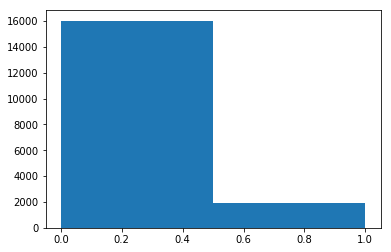

In [11]:
# Add plot
fig, ax = plt.subplots(1, 1)
# Add frequency plot
ax = plt.hist(ds_residues['LIP'], bins=2)

## Feature extraction

### DSSP features (angles, etc.)

In [12]:
# Get DSSP dataframe
ds_dssp = get_DSSP(ds_original.pdb.unique(), pdb_dir)
# Show dataframe
ds_dssp.head()

DEBUG:root:PDB ids:
DEBUG:root:['1cee' '1dev' '1dow' '1fqj' '1g3j' '1hrt' '1i7w' '1j2j' '1jsu' '1kil'
 '1l8c' '1p4q' '1pq1' '1q68' '1rf8' '1sc5' '1sqq' '1tba' '1th1' '1xtg'
 '1ymh' '1zoq' '2a6q' '2auh' '2c1t' '2o8a' '3b71' '1a3b' '1k2d' '1ej4'
 '1mv0' '1t08' '1hv2' '1p16' '1ee5' '1ozs' '2phe' '1sb0' '1j2x' '1axc'
 '2gl7' '1h2k' '1ycq' '1p22' '2iv8' '1tce' '1r1r' '1mxl' '2fym' '1iwq'
 '1fv1' '1dpj' '2b3g' '2nl9' '1o9a' '1sqk' '1nx1' '2gsi' '1i8h' '1p4b'
 '2ivz' '1lm8' '1emu' '1un0' '1a81' '2oq1' '1kdx' '1h8b' '1dt7' '2pg1'
 '1apm' '1cqt']
DEBUG:root:PDB directory: './pdb_files'


,PDB_ID,CHAIN_ID,RES_ID,DSSP_ID,AA,SEC_STRUCT,REL_ASA,PHI,PSI,NH_O_1_relidx,NH_O_1_energy,O_NH_1_relidx,O_NH_1_energy,NH_O_2_relidx,H_O_2_energy,O_NH_2_relidx,O_NH_2_energy
0,1cee,A,1,1,M,-,1,360.0,97.6,0,0.0,2,-0.3,0,0.0,50,-0.1
1,1cee,A,2,2,Q,-,0.348485,-91.3,147.8,48,-0.1,50,-1.7,51,-0.0,2,-0.3
2,1cee,A,3,3,T,E,0.387324,-142.6,136.7,-2,-0.3,50,-0.2,48,-0.2,2,-0.2
3,1cee,A,4,4,I,E,0.00591716,-94.3,154.4,48,-1.9,50,-1.6,-2,-0.3,2,-0.6
4,1cee,A,5,5,K,E,0.346341,-112.5,70.5,-2,-0.2,71,-1.6,48,-0.1,2,-0.8


In [13]:
# Check NULL values in PHI and PSI columns
assert False == bool(ds_dssp.PHI.isnull().any())

In [14]:
# Drop useless features
ds_dssp.drop(['DSSP_ID', 'AA'], axis=1, inplace=True)
ds_dssp.head()

,PDB_ID,CHAIN_ID,RES_ID,SEC_STRUCT,REL_ASA,PHI,PSI,NH_O_1_relidx,NH_O_1_energy,O_NH_1_relidx,O_NH_1_energy,NH_O_2_relidx,H_O_2_energy,O_NH_2_relidx,O_NH_2_energy
0,1cee,A,1,-,1,360.0,97.6,0,0.0,2,-0.3,0,0.0,50,-0.1
1,1cee,A,2,-,0.348485,-91.3,147.8,48,-0.1,50,-1.7,51,-0.0,2,-0.3
2,1cee,A,3,E,0.387324,-142.6,136.7,-2,-0.3,50,-0.2,48,-0.2,2,-0.2
3,1cee,A,4,E,0.00591716,-94.3,154.4,48,-1.9,50,-1.6,-2,-0.3,2,-0.6
4,1cee,A,5,E,0.346341,-112.5,70.5,-2,-0.2,71,-1.6,48,-0.1,2,-0.8


In [15]:
# Drop useless columns from residues dataset
if 'PHI' in ds_residues.columns:
    ds_residues.drop(['PHI', 'PSI'], axis=1, inplace=True)
# Merge DSSP features in ds_residues dataset
ds_residues = ds_residues.merge(ds_dssp, on=['PDB_ID', 'CHAIN_ID', 'RES_ID'], how='left')
# Check new datset
ds_residues.head()

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP,SEC_STRUCT,REL_ASA,PHI,PSI,NH_O_1_relidx,NH_O_1_energy,O_NH_1_relidx,O_NH_1_energy,NH_O_2_relidx,H_O_2_energy,O_NH_2_relidx,O_NH_2_energy
0,1cee,0,A,1,MET,0,0,-,1,360.0,97.6,0.0,0.0,2.0,-0.3,0.0,0.0,50.0,-0.1
1,1cee,0,A,2,GLN,0,0,-,0.348485,-91.3,147.8,48.0,-0.1,50.0,-1.7,51.0,-0.0,2.0,-0.3
2,1cee,0,A,3,THR,0,0,E,0.387324,-142.6,136.7,-2.0,-0.3,50.0,-0.2,48.0,-0.2,2.0,-0.2
3,1cee,0,A,4,ILE,0,0,E,0.00591716,-94.3,154.4,48.0,-1.9,50.0,-1.6,-2.0,-0.3,2.0,-0.6
4,1cee,0,A,5,LYS,0,0,E,0.346341,-112.5,70.5,-2.0,-0.2,71.0,-1.6,48.0,-0.1,2.0,-0.8


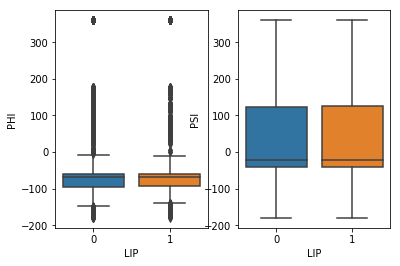

In [16]:
fig, ax = plt.subplots(1, 2)
sns.boxplot(x='LIP', y='PHI',data=ds_residues, ax=ax[0])
sns.boxplot(x='LIP', y='PSI',data=ds_residues, ax=ax[1])

### RING features

In [17]:
# Define folder for ring files
ring_dir = './ring_files'
# Define PDB files for which RING feature extraction is required
pdb_ids = ds_original.pdb.unique()[0:2]
# Define contact treshold to consider
contact_threshold = 3.5
# Flag for actually extract RING files
enable_ring = False

In [18]:
if enable_ring:
    # Download required RING files
    download_RING(pdb_ids, ring_dir)

In [19]:
# Get edges info from RING
ds_ring = get_RING(pdb_ids, pdb_dir, ring_dir, contact_threshold)
ds_ring.head()

,PDB_ID,CHAIN_ID_A,RES_ID_A,CHAIN_ID_B,RES_ID_B,EDGE_LOC,ATOM_A,ATOM_B,EDGE_TYPE
0,1cee,A,180,A,16,LIG_SC,HZ2,MG,IAC
1,1cee,A,16,A,180,LIG_SC,MG,HZ2,IAC
2,1cee,A,180,A,17,LIG_SC,HG1,MG,IAC
3,1cee,A,17,A,180,LIG_SC,MG,HG1,IAC
4,1cee,A,180,A,17,LIG_SC,OG1,MG,IAC


In [20]:
# Get the number of intra chains contacts for every residue
intra_contacts = (ds_ring[ds_ring.CHAIN_ID_A == ds_ring.CHAIN_ID_B]
                        .groupby(['PDB_ID', 'CHAIN_ID_A', 'RES_ID_A'], as_index=False)
                        .size()
                        .reset_index(name='COUNTS'))
intra_contacts.columns = ['PDB_ID', 'CHAIN_ID', 'RES_ID', 'INTRA_CONTACTS']
intra_contacts.RES_ID = intra_contacts.RES_ID.astype(np.int64)
intra_contacts.head()

,PDB_ID,CHAIN_ID,RES_ID,INTRA_CONTACTS
0,1cee,A,101,3
1,1cee,A,109,4
2,1cee,A,11,1
3,1cee,A,110,1
4,1cee,A,111,4


In [21]:
# Get the number of inter chains contacts for every residue
inter_contacts = (ds_ring[ds_ring.CHAIN_ID_A != ds_ring.CHAIN_ID_B]
                        .groupby(['PDB_ID', 'CHAIN_ID_A', 'RES_ID_A'], as_index=False)
                        .size()
                        .reset_index(name='COUNTS'))
inter_contacts.columns = ['PDB_ID', 'CHAIN_ID', 'RES_ID', 'INTER_CONTACTS']
inter_contacts.RES_ID = inter_contacts.RES_ID.astype(np.int64)
inter_contacts.head()

,PDB_ID,CHAIN_ID,RES_ID,INTER_CONTACTS
0,1cee,A,174,3
1,1cee,A,177,4
2,1cee,A,179,3
3,1cee,A,2,1
4,1cee,A,24,2


In [22]:
# Merge intra chain contacts into the main dataset
ds_residues = pd.merge(ds_residues, intra_contacts, how="left", on=['PDB_ID', 'CHAIN_ID', 'RES_ID'])
ds_residues.head()

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP,SEC_STRUCT,REL_ASA,PHI,PSI,NH_O_1_relidx,NH_O_1_energy,O_NH_1_relidx,O_NH_1_energy,NH_O_2_relidx,H_O_2_energy,O_NH_2_relidx,O_NH_2_energy,INTRA_CONTACTS
0,1cee,0,A,1,MET,0,0,-,1,360.0,97.6,0.0,0.0,2.0,-0.3,0.0,0.0,50.0,-0.1,NaN
1,1cee,0,A,2,GLN,0,0,-,0.348485,-91.3,147.8,48.0,-0.1,50.0,-1.7,51.0,-0.0,2.0,-0.3,2.0
2,1cee,0,A,3,THR,0,0,E,0.387324,-142.6,136.7,-2.0,-0.3,50.0,-0.2,48.0,-0.2,2.0,-0.2,NaN
3,1cee,0,A,4,ILE,0,0,E,0.00591716,-94.3,154.4,48.0,-1.9,50.0,-1.6,-2.0,-0.3,2.0,-0.6,5.0
4,1cee,0,A,5,LYS,0,0,E,0.346341,-112.5,70.5,-2.0,-0.2,71.0,-1.6,48.0,-0.1,2.0,-0.8,2.0


In [23]:
# Merge inter chain contacts into the main dataset
ds_residues = pd.merge(ds_residues, inter_contacts, how="left", on=['PDB_ID', 'CHAIN_ID', 'RES_ID'])
ds_residues.head()

,PDB_ID,MODEL_ID,CHAIN_ID,RES_ID,RES_NAME,LIP_SCORE,LIP,SEC_STRUCT,REL_ASA,PHI,...,NH_O_1_relidx,NH_O_1_energy,O_NH_1_relidx,O_NH_1_energy,NH_O_2_relidx,H_O_2_energy,O_NH_2_relidx,O_NH_2_energy,INTRA_CONTACTS,INTER_CONTACTS
0,1cee,0,A,1,MET,0,0,-,1,360.0,...,0.0,0.0,2.0,-0.3,0.0,0.0,50.0,-0.1,NaN,NaN
1,1cee,0,A,2,GLN,0,0,-,0.348485,-91.3,...,48.0,-0.1,50.0,-1.7,51.0,-0.0,2.0,-0.3,2.0,1.0
2,1cee,0,A,3,THR,0,0,E,0.387324,-142.6,...,-2.0,-0.3,50.0,-0.2,48.0,-0.2,2.0,-0.2,NaN,NaN
3,1cee,0,A,4,ILE,0,0,E,0.00591716,-94.3,...,48.0,-1.9,50.0,-1.6,-2.0,-0.3,2.0,-0.6,5.0,NaN
4,1cee,0,A,5,LYS,0,0,E,0.346341,-112.5,...,-2.0,-0.2,71.0,-1.6,48.0,-0.1,2.0,-0.8,2.0,NaN


In [ ]:
# Fill Nan with zeroes
ds_residues.fillna()